In [1]:
# Load required libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import seaborn as sns
import sys
sys.setrecursionlimit(1500)
%matplotlib inline

In [2]:
df_model = pd.read_csv('최종데이터/image_train_1.csv')
df_model

,text,label
0,"\nMicro Center\nCHICAGO, IL 60647 (773)\nRefer...",ham
1,"\nGet QEGY First Thing On Monday Oct 23, This ...",spam
2,\nAnti-LGBT: States that have laws restricting...,ham
3,\nRecent Announcements Indicate Climb For ag a...,spam
4,\nIssue 559\nWall Street Times Investor Alert ...,spam
...,...,...
1168,\n****! READ IT CAREFULLY!**\nNew Product Incr...,spam
1169,\nGDKI.PK IS POISED TO EXPLODE!\nTHIS ONE COUL...,spam
1170,\nROAD AHEAD CLOSED,ham
1171,\nGDKI IS PUTTING CASH IN INVESTORS' POCKETS! ...,spam


In [3]:
df_unseen_test = pd.read_csv('최종데이터/image_test_1.csv')
df_unseen_test

,text,label
0,\nADS FOR MONSTERS\nMADHOUSE SALUTES THE TRANS...,ham
1,\nBest stock Pick for this Year.\nGet ARSS Fir...,spam
2,\n• Lowest Price Guarantee Fast Delivery\nFor ...,spam
3,\nLOUIS VUITTON\nPARIS\nmade in France,ham
4,\n• Lowest Price Guarantee Fast Delivery\nFor ...,spam
...,...,...
57,\nNERDS ANONYMOUS\nCreated by Jared Bonner and...,ham
58,\nCANAL DE PANAMA\nABIER\nMIRAFLORES LOCKS PAN...,ham
59,\nLowest Price Guarantee & Fast Delivery\n100%...,spam
60,\nWATCH OUT!\nSBNS MAKES A MOVE!\nWATCH SBNS T...,spam


In [4]:
NEWLINE = '\n'

def token_count(row):
    'returns token count'
    text=row['tokenized_text']
    length=len(text.split())
    return length

def tokenize(row):
    "tokenize the text using default space tokenizer"
    text=row['text']
    lines=(line for line in text.split(NEWLINE) )
    tokenized=""
    for sentence in lines:
        tokenized+= " ".join(tok for tok in sentence.split())
    return tokenized

In [5]:
df_model['tokenized_text']=df_model.apply(tokenize, axis=1)
df_model['token_count']=df_model.apply(token_count, axis=1)
df_model['lang']='en'
df_model.head()

,text,label,tokenized_text,token_count,lang
0,"\nMicro Center\nCHICAGO, IL 60647 (773)\nRefer...",ham,"Micro CenterCHICAGO, IL 60647 (773)Reference: ...",16,en
1,"\nGet QEGY First Thing On Monday Oct 23, This ...",spam,"Get QEGY First Thing On Monday Oct 23, This Is...",122,en
2,\nAnti-LGBT: States that have laws restricting...,ham,Anti-LGBT: States that have laws restricting t...,18,en
3,\nRecent Announcements Indicate Climb For ag a...,spam,Recent Announcements Indicate Climb For ag aoP...,231,en
4,\nIssue 559\nWall Street Times Investor Alert ...,spam,Issue 559Wall Street Times Investor Alert ****...,78,en


In [6]:
df_unseen_test['tokenized_text']=df_unseen_test.apply(tokenize, axis=1)
df_unseen_test['token_count']=df_unseen_test.apply(token_count, axis=1)
df_unseen_test['lang']='en'
df_unseen_test.head()

,text,label,tokenized_text,token_count,lang
0,\nADS FOR MONSTERS\nMADHOUSE SALUTES THE TRANS...,ham,ADS FOR MONSTERSMADHOUSE SALUTES THE TRANSYLVA...,69,en
1,\nBest stock Pick for this Year.\nGet ARSS Fir...,spam,Best stock Pick for this Year.Get ARSS First T...,122,en
2,\n• Lowest Price Guarantee Fast Delivery\nFor ...,spam,• Lowest Price Guarantee Fast DeliveryFor Free...,59,en
3,\nLOUIS VUITTON\nPARIS\nmade in France,ham,LOUIS VUITTONPARISmade in France,4,en
4,\n• Lowest Price Guarantee Fast Delivery\nFor ...,spam,• Lowest Price Guarantee Fast DeliveryFor More...,41,en


In [7]:
# Lets look at some information related to the data
print("total emails : ", len(df_model))
print  ("total spam emails : ", len(df_model[df_model['label']=='spam']) )
print  ("total normal emails : ", len(df_model[df_model['label']=='ham']) )

total emails :  1173
total spam emails :  608
total normal emails :  565


Text(0.5, 1.0, 'Token length Vs Frequency for Enron Spam Emails')

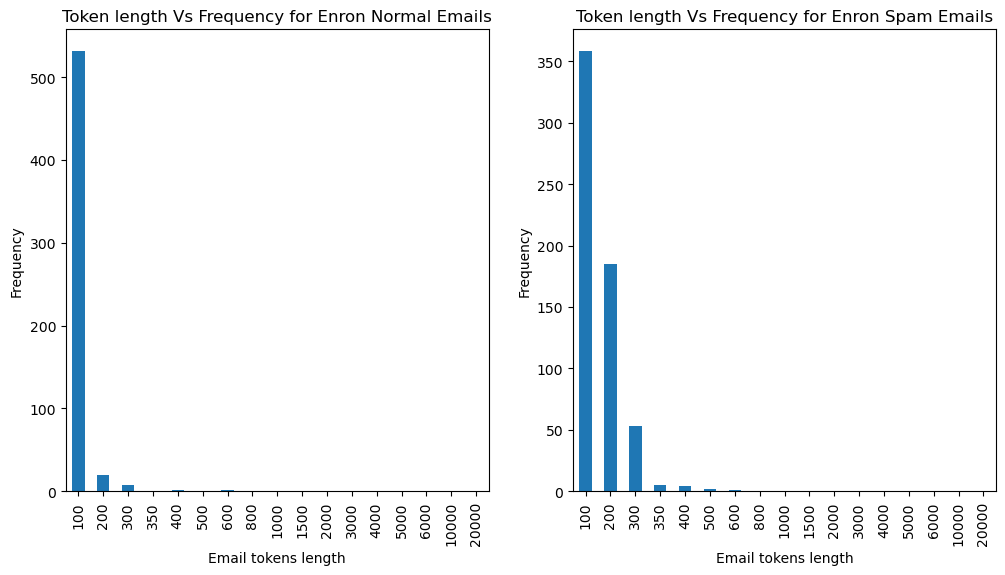

In [8]:
bins = [0,100,200,300,350,400,500,600,800,1000,1500,2000,3000,4000,5000,6000,10000,20000]


fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12, 6))
fig.subplots_adjust(hspace=.5)

df_model_sub=df_model[ (df_model['lang']=='en') & (df_model['label']=='ham')]
df_model1 = df_model_sub.groupby(pd.cut(df_model_sub['token_count'], bins=bins)).token_count.count()
df_model1.index=[a.right for a in df_model1.index]
res1=df_model1.plot(kind='bar',ax=axes[0])
res1.set_xlabel('Email tokens length')
res1.set_ylabel('Frequency')
res1.set_title('Token length Vs Frequency for Enron Normal Emails')


df_model_sub=df_model[ (df_model['lang']=='en') & (df_model['label']=='spam')]
df_model1 = df_model_sub.groupby(pd.cut(df_model_sub['token_count'], bins=bins)).token_count.count()
df_model1.index=[a.right for a in df_model1.index]
res2=df_model1.plot(kind='bar',ax=axes[1])
res2.set_xlabel('Email tokens length')
res2.set_ylabel('Frequency')
res2.set_title('Token length Vs Frequency for Enron Spam Emails')

## Model

In [9]:
import keras

from keras.layers import Input, Dense
from keras.models import Model,load_model
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, TensorBoard

In [10]:
import sklearn
from sklearn import metrics
from sklearn import svm
import joblib
from sklearn.preprocessing import LabelEncoder

In [11]:
# max number of features
num_max = 600

In [12]:
def train_tf_idf_model(texts):
    "train tf idf model "
    tic = time.process_time()
    

    tok = Tokenizer(num_words=num_max)
    tok.fit_on_texts(texts)
    toc = time.process_time()

    print (" -----total Computation time = " + str((toc - tic)) + " seconds")
    return tok


def prepare_model_input(tfidf_model,dataframe,mode='tfidf'):
    
    "function to prepare data input features using tfidf model"
    tic = time.process_time()
    
    le = LabelEncoder()
    sample_texts = list(dataframe['tokenized_text'])
    sample_texts = [' '.join(x.split()) for x in sample_texts]
    
    targets=list(dataframe['label'])
    targets = [1. if x=='spam' else 0. for x in targets]
    sample_target = le.fit_transform(targets)
    
    if mode=='tfidf':
        sample_texts=tfidf_model.texts_to_matrix(sample_texts,mode='tfidf')
    else:
        sample_texts=tfidf_model.texts_to_matrix(sample_texts)
    
    toc = time.process_time()
    
    print('shape of labels: ', sample_target.shape)
    print('shape of data: ', sample_texts.shape)
    
    print (" -----total Computation time for preparing model data = " + str((toc - tic)) + " seconds")
    
    return sample_texts,sample_target

In [13]:
texts=list(df_model['tokenized_text'])
tfidf_model=train_tf_idf_model(texts)

 -----total Computation time = 0.125 seconds


In [14]:
# prepare model input data
mat_texts,tags=prepare_model_input(tfidf_model,df_model,mode='tfidf')

shape of labels:  (1173,)
shape of data:  (1173, 600)
 -----total Computation time for preparing model data = 0.375 seconds


# Split Train/validation data 

We will use 85% for training, 15% for validation. 

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(mat_texts, tags, test_size=0.15, random_state=42)
print ('train data shape: ', X_train.shape, y_train.shape)
print ('validation data shape :' , X_val.shape, y_val.shape)

train data shape:  (997, 600) (997,)
validation data shape : (176, 600) (176,)


In [16]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 3.97031989, 2.51711123, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 2.03547698, 2.86216199, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.86876846, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
model_save_path="checkpoints/spam_detector_enron_model3.h5"

In [18]:
def get_simple_model():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(num_max,)))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',keras.metrics.binary_accuracy])
    print('compile done')
    return model

def check_model(model,x,y,epochs=2):
    history=model.fit(x,y,batch_size=32,epochs=epochs,verbose=1,shuffle=True,validation_split=0.2,
              callbacks=[checkpointer, tensorboard]).history
    return history


def check_model2(model,x_train,y_train,x_val,y_val,epochs=10):
    history=model.fit(x_train,y_train,batch_size=64,
                      epochs=epochs,verbose=1,
                      shuffle=True,
                      validation_data=(x_val, y_val),
                      callbacks=[checkpointer, tensorboard]).history
    return history

# define checkpointer
checkpointer = ModelCheckpoint(filepath=model_save_path,
                               verbose=1,
                               save_best_only=True)    

# define tensorboard
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)


# define the predict function for the deep learning model for later use
def predict(data):
    result=model.predict(data)
    prediction = [round(x[0]) for x in result]
    return prediction

## Model train

In [19]:
# get the compiled model
model = get_simple_model()

# load history
# history=check_model(m,mat_texts,tags,epochs=10)
history=check_model2(model,X_train,y_train,X_val,y_val,epochs=30)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               307712    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 439297 (1.68 MB)
Trainable params: 439297 (1.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
compile done
Epoch 1

C:\Users\JAE\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 0.2336 - acc: 0.9789 - binary_accuracy: 0.9789
Epoch 2: val_loss improved from 0.30274 to 0.16772, saving model to checkpoints\spam_detector_enron_model3.h5
16/16 [==============================] - 0s 18ms/step - loss: 0.2336 - acc: 0.9789 - binary_accuracy: 0.9789 - val_loss: 0.1677 - val_acc: 0.9943 - val_binary_accuracy: 0.9943
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.1326 - acc: 0.9779 - binary_accuracy: 0.9779
Epoch 3: val_loss improved from 0.16772 to 0.08735, saving model to checkpoints\spam_detector_enron_model3.h5
16/16 [==============================] - 0s 19ms/step - loss: 0.1326 - acc: 0.9779 - binary_accuracy: 0.9779 - val_loss: 0.0874 - val_acc: 0.9943 - val_binary_accuracy: 0.9943
Epoch 4/30
14/16 [=========================>....] - ETA: 0s - loss: 0.0706 - acc: 0.9877 - binary_accuracy: 0.9877
Epoch 4: val_loss improved from 0.08735 to 0.04736, saving model to checkpoints\spam_detector_

11/16 [===================>..........] - ETA: 0s - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000   
Epoch 25: val_loss did not improve from 0.00823
16/16 [==============================] - 0s 15ms/step - loss: 0.0074 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0101 - val_acc: 0.9943 - val_binary_accuracy: 0.9943
Epoch 26/30
11/16 [===================>..........] - ETA: 0s - loss: 0.0092 - acc: 0.9986 - binary_accuracy: 0.9986
Epoch 26: val_loss did not improve from 0.00823
16/16 [==============================] - 0s 15ms/step - loss: 0.0069 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0128 - val_acc: 0.9943 - val_binary_accuracy: 0.9943
Epoch 27/30
13/16 [=======================>......] - ETA: 0s - loss: 0.0081 - acc: 0.9988 - binary_accuracy: 0.9988   
Epoch 27: val_loss did not improve from 0.00823
16/16 [==============================] - 0s 15ms/step - loss: 0.0070 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0165 - val_acc: 0.9943 - val_binary_acc

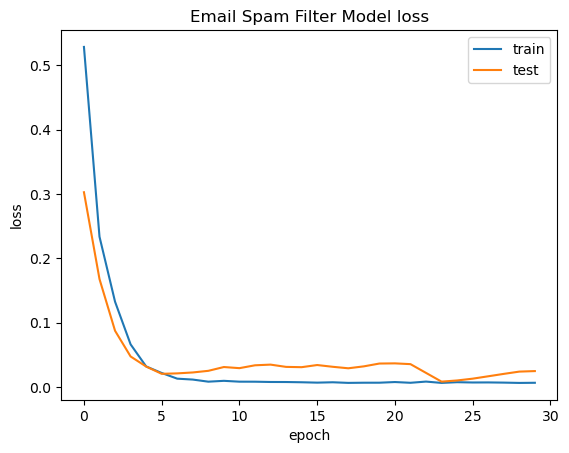

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Email Spam Filter Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

## Model Performance

In [21]:
sample_texts,sample_target=prepare_model_input(tfidf_model,df_unseen_test,mode='')

shape of labels:  (62,)
shape of data:  (62, 600)
 -----total Computation time for preparing model data = 0.03125 seconds


In [22]:
# lets write a function to create the dataframe of the results from all the models
model_dict={}
model_dict['deep_learning']=model


def getResults(model_dict,sample_texts,sample_target):
    '''
    Get results from different models
    '''
    results=[]
    
    results_cm={}
    
    for name,model in model_dict.items():
#         print(name)
        tic1 = time.process_time()
        if name in 'deep_learning':
            predicted_sample = predict(sample_texts)
        else:    
            predicted_sample = model.predict(sample_texts)
        toc1 = time.process_time()
#         print(predicted_sample)

        cm=sklearn.metrics.confusion_matrix(sample_target, predicted_sample)
        results_cm[name]=cm
        
        total=len(predicted_sample)
        TP = cm[0][0]
        FP = cm[0][1]
        FN = cm[1][0]
        TN = cm[1][1]
        
        time_taken=round(toc1 - tic1,4)
        res=sklearn.metrics.precision_recall_fscore_support(sample_target, predicted_sample)
        results.append([name,np.mean(res[0]),np.mean(res[1]),np.mean(res[2]),total,TP,FP,FN,TN,str(time_taken)] )
        
        
    
    df_cols=['model','precision','recall','f1_score','Total_samples','TP','FP','FN','TN','execution_time']
    result_df=pd.DataFrame(results,columns=df_cols)
    
    return result_df,results_cm

In [23]:
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

2/2 [==============================] - 0s 0s/step


,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN,execution_time
0,deep_learning,1.0,1.0,1.0,62,33,0,0,29,0.2031


In [24]:
def plot_heatmap(cm,title):
    df_cm2 = pd.DataFrame(cm, index = ['normal', 'spam'])
    df_cm2.columns=['normal','spam']

    ax = plt.axes()
    sns.heatmap(df_cm2, annot=True, fmt="d", linewidths=.5,ax=ax)
    ax.set_title(title)
    plt.show()
    return

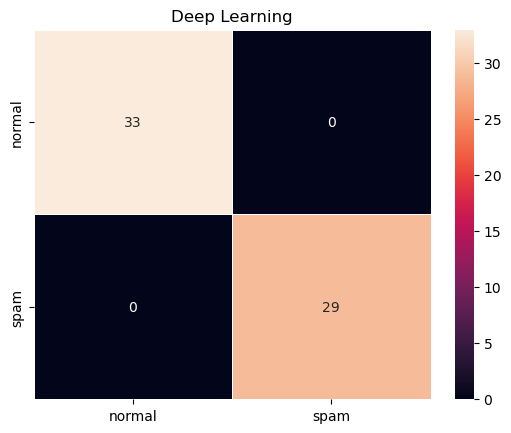

In [25]:
plot_heatmap(results_cm['deep_learning'],'Deep Learning')

## 다른 테스트 셋
### create(GPT)

In [26]:
create = pd.read_csv('최종데이터/create_test_1.csv')
create

,text,label
0,Subject: Limited Spots Left - Grab Yours Now! ...,spam
1,"Hi jane,\n\nKeep creating and exploring your p...",ham
2,Subject: No More Debt Worries: Recover Instant...,spam
3,Subject: A Truly Joyful Trip\nHi Jinger@@@\nI ...,ham
4,Grateful for our friendship. You mean a lot to...,ham
...,...,...
195,Subject: Your Guaranteed Satisfaction\n\nHi ma...,spam
196,Looking for a bargain? Compare rates and save ...,spam
197,"Hello clinst,\n\nElevate your education with o...",spam
198,Subject: Request for Exchange due to iPad Soun...,ham


In [27]:
create['tokenized_text']=create.apply(tokenize, axis=1)
create['token_count']=create.apply(token_count, axis=1)
create['lang']='en'

sample_texts,sample_target=prepare_model_input(tfidf_model,create,mode='')
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

shape of labels:  (200,)
shape of data:  (200, 600)
 -----total Computation time for preparing model data = 0.015625 seconds
7/7 [==============================] - 0s 3ms/step


,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN,execution_time
0,deep_learning,0.743455,0.542056,0.405051,200,93,0,98,9,0.1562


### collect

In [28]:
collect = pd.read_csv('최종데이터/collect_test_1.csv')
collect

,text,label
0,business in history that requires no work. NO...,spam
1,"I'm in a meeting, call me later at",ham
2,"re : var for metals\nted , anjam ' s and myse...",ham
3,My love ! How come it took you so long to leav...,ham
4,I AM AT THE GAS STATION. GO THERE.,ham
...,...,...
300,"At 17:10 22/08/2002 +0100, Nick Hilliard wrote...",spam
301,"URL: http://www.newsisfree.com/click/-2,865571...",spam
302,Welcome to UK-mobile-date this msg is FREE giv...,spam
303,"all graphics software available , cheap oem v...",spam


In [29]:
collect['tokenized_text']=collect.apply(tokenize, axis=1)
collect['token_count']=collect.apply(token_count, axis=1)
collect['lang']='en'

sample_texts,sample_target=prepare_model_input(tfidf_model,collect,mode='')
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

shape of labels:  (305,)
shape of data:  (305, 600)
 -----total Computation time for preparing model data = 0.046875 seconds
10/10 [==============================] - 0s 3ms/step


,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN,execution_time
0,deep_learning,0.620253,0.553656,0.478465,305,139,11,127,28,0.1406


### collect+image

In [30]:
collectimage = pd.read_csv('최종데이터/collectimage_test_16features.csv')
collectimage

,text,special_ratio,number_ratio,url_count,upper_ratio,blank_ratio,crlf_ratio,Noun,Pronoun,Verb,Adjective,Adverb,avg_word_sentences,avg_char_sentences,avg_word_paragraphs,avg_char_paragraphs,label
0,\nFeel young again with Regenisis HGH\nRegenis...,0.118319,0.028868,0,0.067479,0.290053,0.120768,0.362963,0.037037,0.140741,0.088889,0.044444,0.134549,0.136043,0.040308,0.044780,spam
1,\nSuperstar Stock Report\nSmart Money Equities...,0.129388,0.107814,2,0.159635,0.343152,0.030367,0.337097,0.074194,0.140323,0.051613,0.043548,0.126329,0.112799,0.182118,0.194045,spam
2,\nYOU'VE SEEN IT BEFORE YOU SAY? YOU AIN'T SEE...,0.194393,0.308285,0,0.276236,0.308322,0.528875,0.415842,0.016502,0.075908,0.046205,0.019802,0.066148,0.054741,0.099670,0.082251,spam
3,\n****! READ IT CAREFULLY!**\nNew Product Incr...,0.103499,0.041612,0,0.072706,0.334076,0.065231,0.341686,0.056948,0.125285,0.075171,0.041002,0.103684,0.101180,0.141810,0.145145,spam
4,\nDOE MEE\nDOE MEE DOE MEE DOE MEE DOE MEE DOE...,0.123539,0.087075,0,0.474921,0.408219,0.076128,0.581818,0.018182,0.036364,0.000000,0.018182,0.171220,0.135614,0.015024,0.011739,spam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,"\nGet QEGY First Thing On Monday Oct 23, This ...",0.147568,0.246343,0,0.209392,0.360201,0.055422,0.368421,0.010526,0.089474,0.036842,0.015789,0.096210,0.078858,0.054232,0.051699,spam
301,\n??Lowest Price Guarantee Fast Delivery\nFor ...,0.178926,0.270859,2,0.052989,0.371872,0.142004,0.271186,0.090395,0.124294,0.050847,0.045198,0.062253,0.053874,0.055332,0.048433,spam
302,\nLOUIS VUITTON\nPARIS\nmade in FranceUrgent -...,0.111481,0.530387,0,0.308901,0.275880,0.124529,0.500000,0.031250,0.031250,0.062500,0.000000,0.086876,0.094422,0.007329,0.008396,spam
303,\nFeel young again with Regenisis HGH\nRegenis...,0.288982,0.096482,2,0.060748,0.273385,0.124622,0.307500,0.030000,0.122500,0.075000,0.045000,0.214004,0.190966,0.106632,0.127420,spam


In [31]:
collectimage['tokenized_text']=collectimage.apply(tokenize, axis=1)
collectimage['token_count']=collectimage.apply(token_count, axis=1)
collectimage['lang']='en'

sample_texts,sample_target=prepare_model_input(tfidf_model,collectimage,mode='')
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

shape of labels:  (305,)
shape of data:  (305, 600)
 -----total Computation time for preparing model data = 0.109375 seconds
10/10 [==============================] - 0s 4ms/step


,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN,execution_time
0,deep_learning,0.739044,0.798535,0.733857,305,76,8,68,153,0.125


### create+image

In [32]:
createimage = pd.read_csv('최종데이터/createimage_test_16features.csv')
createimage

,text,special_ratio,number_ratio,url_count,upper_ratio,blank_ratio,crlf_ratio,Noun,Pronoun,Verb,Adjective,Adverb,avg_word_sentences,avg_char_sentences,avg_word_paragraphs,avg_char_paragraphs,label
0,\nPARK HYATT TOKYOSubject: Congratulations! Yo...,0.530790,0.203366,1,0.129727,0.475949,0.356645,0.387755,0.081633,0.102041,0.081633,0.040816,0.059309,0.074385,0.010664,0.009254,spam
1,\nFNLH EXPLODES ON THE INVESTOR SCENE!!!\nTHIS...,0.377405,0.133960,0,0.223838,0.837510,0.193030,0.340996,0.068966,0.122605,0.053640,0.022989,0.171922,0.165509,0.092417,0.074148,spam
2,\nDANGER\nThis beach Lumahai is NOT A WARNING ...,0.256490,0.000000,0,0.185293,0.638729,0.505035,0.361446,0.060241,0.096386,0.060241,0.060241,0.066631,0.068221,0.021801,0.014104,ham
3,\nThis may turn out to be the most important e...,0.318424,0.123090,0,0.107310,0.742559,0.161889,0.368932,0.043689,0.123786,0.053398,0.026699,0.196847,0.210125,0.194905,0.178347,spam
4,\nGDKI.PK IS POISED TO EXPLODE!\nTHIS ONE COUL...,0.462681,0.208157,0,0.467605,0.701375,0.291156,0.512821,0.019231,0.070513,0.035256,0.016026,0.182838,0.181061,0.109005,0.094865,spam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,\nBIG NEWS\nARE HITTING ON FRIDAY FOR CRSVF!!!...,0.422137,0.110708,1,0.377725,0.613151,0.231352,0.479029,0.017660,0.075055,0.048565,0.015453,0.209218,0.226992,0.277251,0.275786,spam
182,\nHoodia Maximum Strength\nFinally... A Natura...,0.289102,0.096566,0,0.112412,0.631050,0.363225,0.401361,0.081633,0.122449,0.054422,0.034014,0.168511,0.186529,0.139810,0.125238,spam
183,\nLowest Price Guarantee & Fast Delivery\n100%...,0.711749,1.000000,3,0.119216,0.637573,0.440688,0.403361,0.042017,0.109244,0.016807,0.033613,0.439660,0.441485,0.225118,0.194148,spam
184,\nMastering MuseScore\nMarc Sabate\nMastering ...,0.000000,0.137235,0,0.172633,0.076582,0.922754,0.704918,0.049180,0.049180,0.049180,0.000000,0.193451,0.290367,0.125592,0.137527,spam


In [33]:
createimage['tokenized_text']=createimage.apply(tokenize, axis=1)
createimage['token_count']=createimage.apply(token_count, axis=1)
createimage['lang']='en'

sample_texts,sample_target=prepare_model_input(tfidf_model,createimage,mode='')
result_df,results_cm= getResults(model_dict,sample_texts,sample_target)
result_df

shape of labels:  (186,)
shape of data:  (186, 600)
 -----total Computation time for preparing model data = 0.046875 seconds
6/6 [==============================] - 0s 3ms/step


,model,precision,recall,f1_score,Total_samples,TP,FP,FN,TN,execution_time
0,deep_learning,0.733696,0.828671,0.715143,186,43,0,49,94,0.1719
